First, load the data,in this notebook we are using the second Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". The data has been preprocessed in R (refer to the r script in iCloud/UTK/GRA-UTK/SelectMicro/MLonMicrobiome).

2) 836 samples: Flores GE, Caporaso JG, Henley JB, et al. Temporal variability is a personalized feature of the human microbiome. Genome Biol 2014

The result is from sbatch script:

|                  | number      | Random Forest   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.736 (0.040)  |0.731 (0.046)|0.533 (0.080) |0.867 (0.032) |
| SelectMicro| 45  | |0.736 (0.043) |0.731 (0.047) | 0.540 (0.079) |0.880 (0.018) |
| Lasso_finetune    |15  | | 0.670 (0.030)|0.670 (0.032) |0.420 (0.065) |0.809 (0.033) |
| FS_Lasso_finetune |   14 |  | 0.661 (0.022) |0.660 (0.024) |0.408 (0.056) |0.808 (0.027) |


|                  | number      | XGboost   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.736 (0.042)  |0.735 (0.044)|0.540 (0.081)|0.869 (0.023) |
| SelectMicro| 45  | |0.732 (0.041) |0.729 (0.044) |0.536 (0.069) |0.865 (0.023) |
| Lasso_finetune    |15  | | 0.639 (0.027)|0.638 (0.027) |0.364 (0.052) |0.786 (0.029) |
| FS_Lasso_finetune |   14 |  | 0.640 (0.035) |0.640 (0.033) |0.373 (0.061) |0.786 (0.035) |


|                  | number      | SVM   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.578 (0.042)| 0.491 (0.094)| nan (nan)|0.451 (0.208)|
| SelectMicro| 45  | |0.567 (0.036)| 0.474 (0.088)|nan (nan)| 0.452 (0.207) |
| Lasso_finetune    |15  | | 0.584 (0.015)| 0.598 (0.017)|0.350 (0.031)| 0.769 (0.040) |
| FS_Lasso_finetune |   14 |  | 0.571 (0.013)| 0.585 (0.016)|0.331 (0.021)| 0.766 (0.039)|


|                  | number      | NB   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.377 (0.048)|0.397 (0.056)|0.240 (0.083)|0.673 (0.037)|
| SelectMicro| 45  | | 0.443 (0.060)|0.457 (0.074)| 0.288 (0.083)|0.742 (0.052)|
| Lasso_finetune    |15  | |  0.506 (0.013)| 0.461 (0.022)|0.238 (0.058)| 0.729 (0.021) |
| FS_Lasso_finetune |   14 |  | 0.499 (0.025)| 0.448 (0.045)| 0.223 (0.056)| 0.738 (0.024)|

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import scikit_posthocs as sp
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

2025-04-10 13:00:27.454965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 13:00:27.457392: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 13:00:27.461109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 13:00:27.471036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744304427.488138 1671429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744304427.49

In [2]:
qitta_2 = pd.read_csv('../data/features_genus_db1629.csv',index_col=0)

In [3]:
print(qitta_2.shape)

(637, 220)


In [4]:
meta_2 = pd.read_csv('../data/meta_genus_db1629.csv',index_col=0)

In [5]:
# 1. abundance matrix--> relative abundance matrix
cols_name = qitta_2.columns
data = pd.DataFrame(FS.relative_abundance(qitta_2), columns=cols_name)

In [6]:
print(data)
print(np.shape(data))

     g__Neisseria  g__Blautia  g__Turicibacter  f__Peptostreptococcaceae  \
0             0.0    0.023283              0.0                       0.0   
1             0.0    0.045551              0.0                       0.0   
2             0.0    0.035033              0.0                       0.0   
3             0.0    0.026943              0.0                       0.0   
4             0.0    0.038353              0.0                       0.0   
..            ...         ...              ...                       ...   
632           0.0    0.076923              0.0                       0.0   
633           0.0    0.000000              0.0                       0.0   
634           0.0    0.000000              0.0                       0.0   
635           0.0    0.050000              0.0                       0.0   
636           0.0    0.000000              0.0                       0.0   

     f__Burkholderiaceae  g__Aggregatibacter  g__Serratia  g__Sutterella  \
0          

In [7]:
y = meta_2['ibd']

In [8]:
set(y)
# nonIBD: Individuals without IBD (healthy controls).
# CD: Crohn’s Disease.
# UC: Ulcerative Colitis.

{'CD', 'UC', 'nonIBD'}

In [9]:
pd.Series(y).value_counts()

ibd
UC        324
CD        251
nonIBD     62
Name: count, dtype: int64

Perform sigle lable feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

dict_keys(['selected_df', 'selected_indices', 'H_score'])

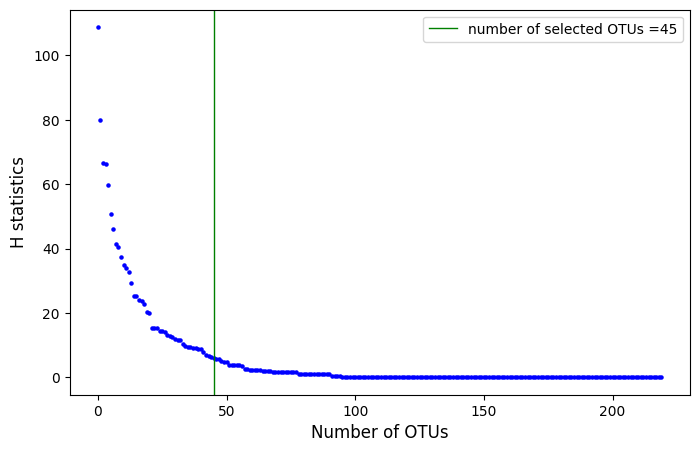

In [10]:
# 2. calculating H score for each OTU
selectedresult=FS.SelectMicro_fun(data,y,p_cutoff = 0.05)

selectedresult.keys()

In [11]:
selectedOTU_index= selectedresult['selected_indices']
X_FS = selectedresult['selected_df']
#selectedASV = X_FS.columns


In [12]:
custom_order = ['nonIBD', 'CD', 'UC']
custom_mapping = {category: i for i, category in enumerate(custom_order)}

In [13]:
target_variable = [custom_mapping[category] for category in y]
target_variable = np.array(target_variable)

In [14]:
dunn_results, summary = FS.calculate_dunn_tests_pair(
    X_FS,
    target_variable,
    p_threshold=0.05
)

In [25]:
# Set pandas to display all rows
pd.set_option('display.max_rows', None)

# Assuming your dataframe is named df
print(summary)

# Optionally, reset back to default if needed
pd.reset_option('display.max_rows')

                       Feature  Group1  Group2       P-value EffectDirection
0           f__Ruminococcaceae       0       1  2.915368e-11             ↑ 0
1           f__Ruminococcaceae       1       2  7.387802e-22             ↑ 2
2        f__Enterobacteriaceae       0       1  1.108421e-09               =
3        f__Enterobacteriaceae       1       2  1.488880e-15               =
4                g__Prevotella       0       1  7.008770e-15             ↑ 0
5                g__Prevotella       0       2  7.520173e-14             ↑ 0
6          g__Faecalibacterium       0       1  5.678213e-03             ↑ 0
7          g__Faecalibacterium       1       2  1.362279e-15             ↑ 2
8               g__Veillonella       0       1  2.044466e-04               =
9               g__Veillonella       1       2  1.027954e-13               =
10  g__Ruminococcus_feature_57       0       1  4.986294e-02             ↑ 0
11  g__Ruminococcus_feature_57       1       2  3.112850e-12             ↑ 2

In [29]:
subset = summary[summary['Group1'] == 1]['Feature'].unique()
subset

array(['f__Ruminococcaceae', 'f__Enterobacteriaceae',
       'g__Faecalibacterium', 'g__Veillonella',
       'g__Ruminococcus_feature_57', 'o__Clostridiales',
       'g__Oscillospira', 'f__Lachnospiraceae', 'g__Fusobacterium',
       'f__Rikenellaceae', 'g__Akkermansia', 'g__Megasphaera',
       'g__Morganella', 'g__Phascolarctobacterium', 'g__Blautia',
       'g__Dorea', 'f__Christensenellaceae', 'g__Parabacteroides',
       'o__RF32', 'g__[Ruminococcus]', 'g__[Eubacterium]',
       'g__Collinsella', 'f__[Chromatiaceae]', 'f__S24-7',
       'o__Bacteroidales', 'g__Lactobacillus', 'g__Enterobacter',
       'f__[Barnesiellaceae]', 'g__Dialister', 'g__Listeria',
       'g__Lachnospira', 'g__Streptococcus', 'g__Alistipes'], dtype=object)

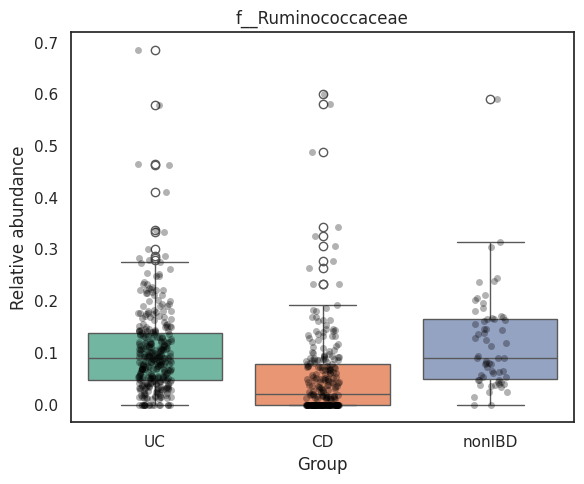

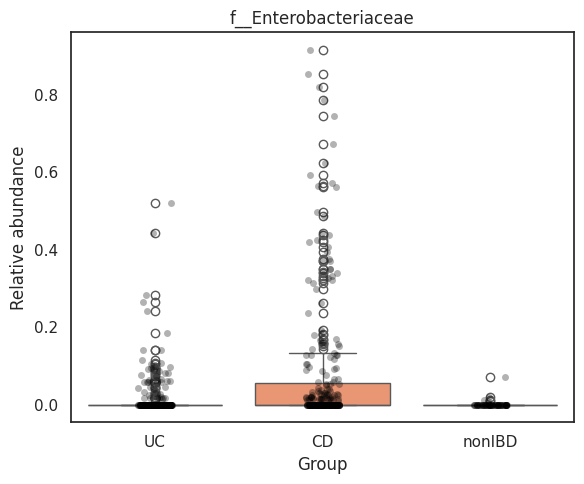

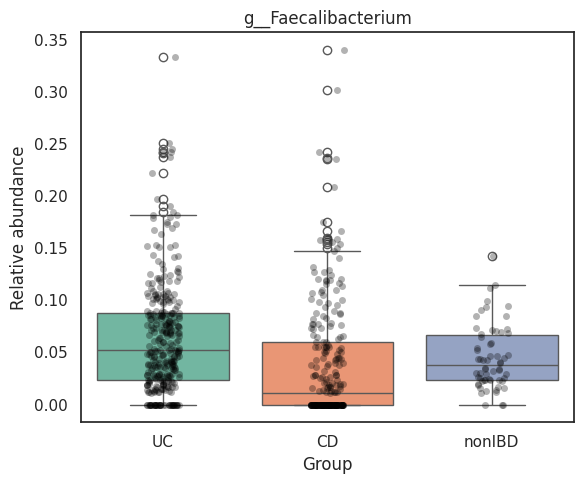

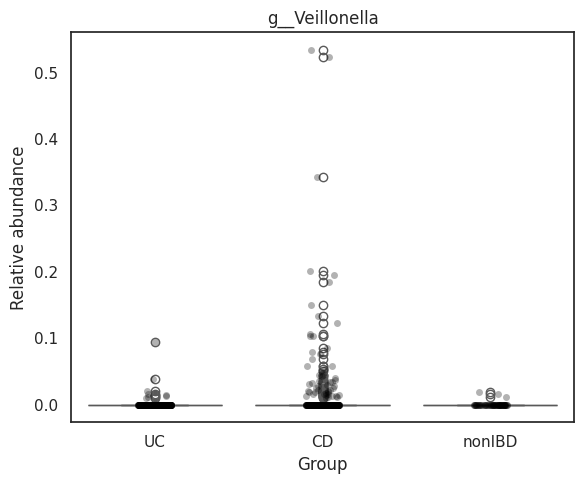

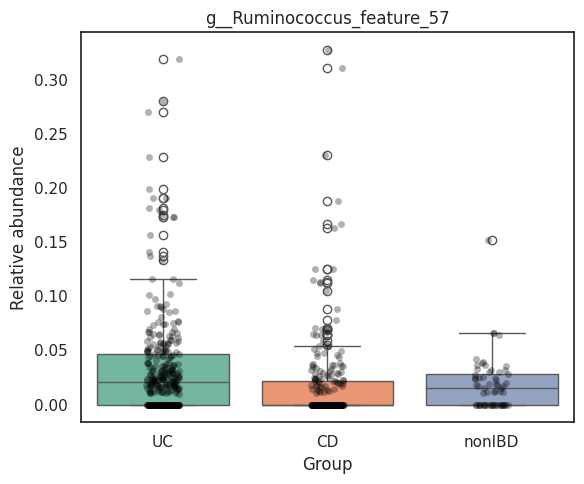

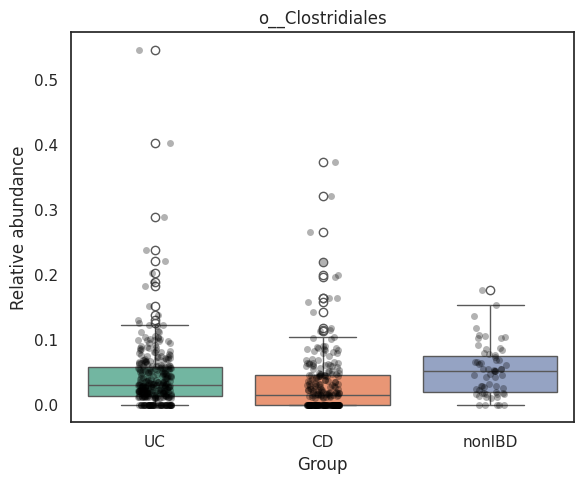

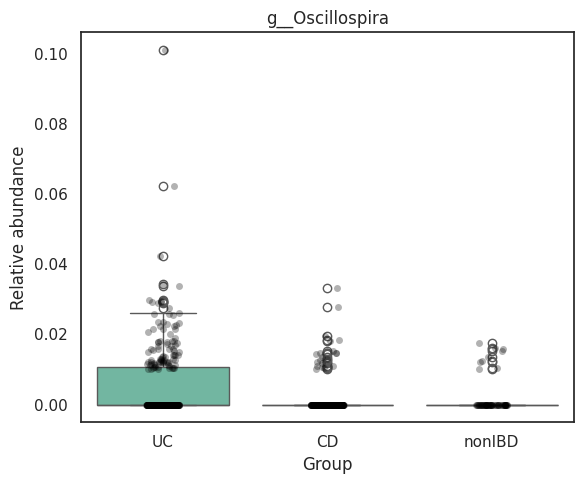

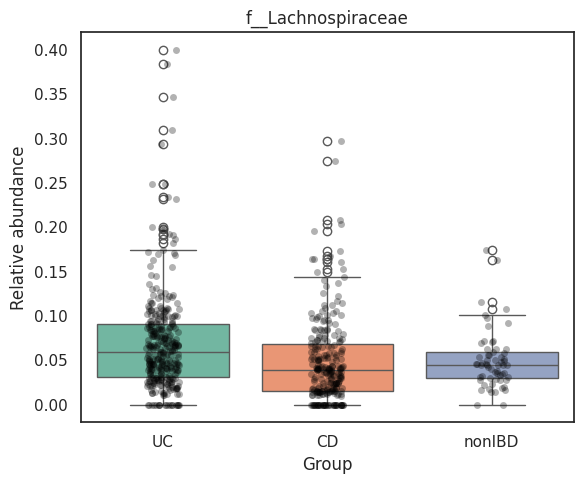

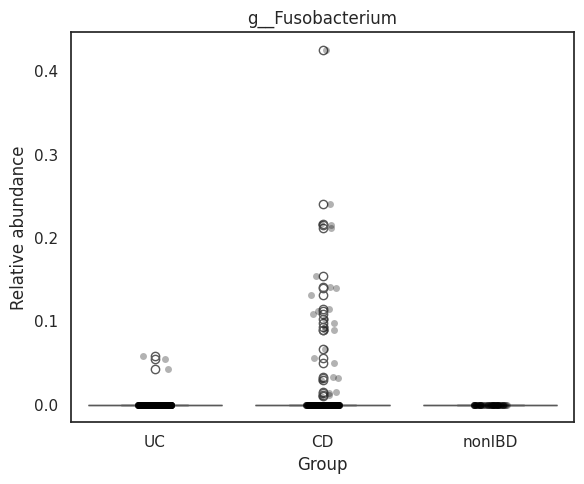

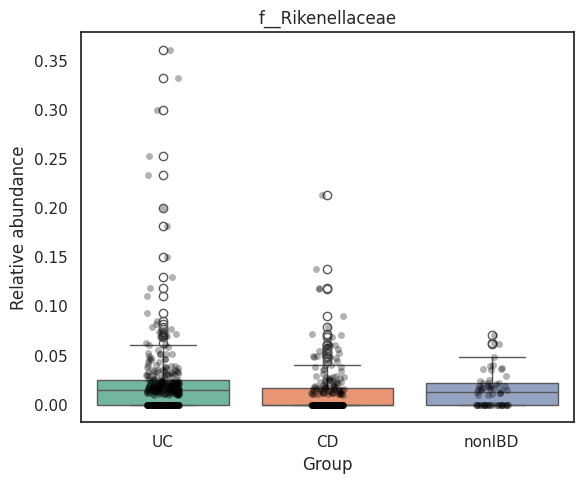

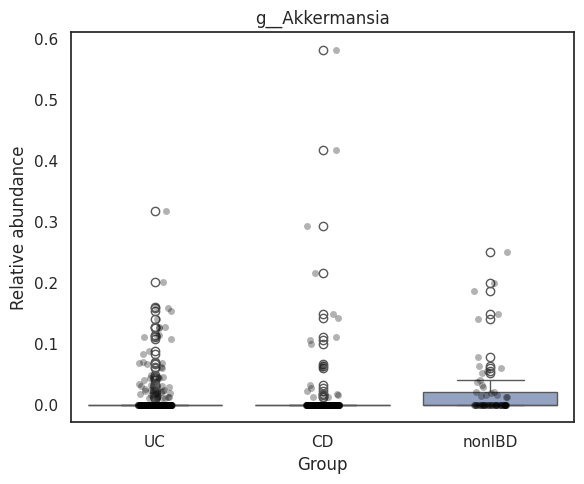

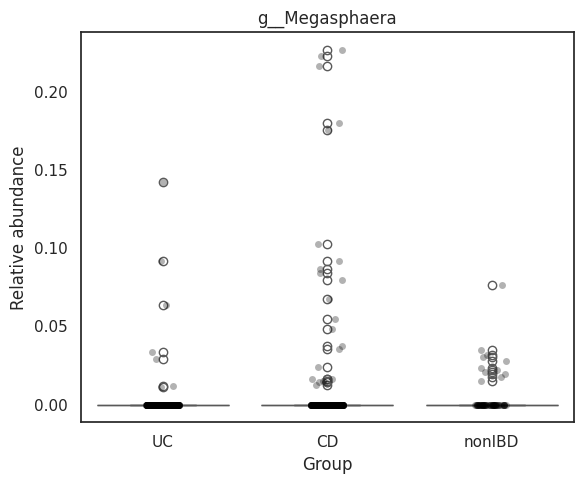

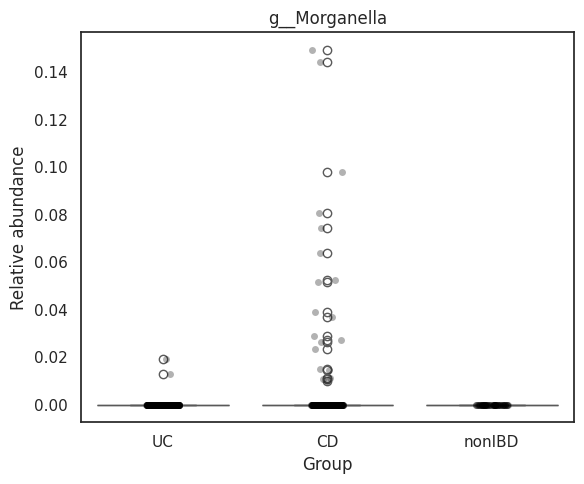

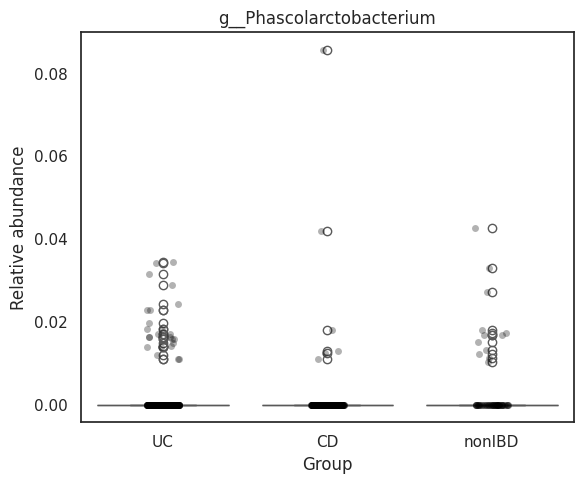

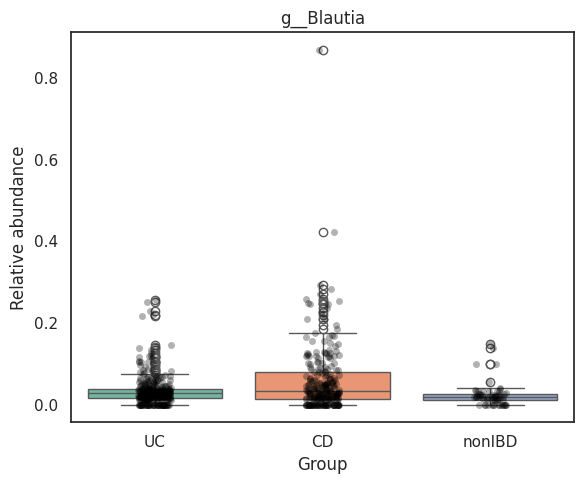

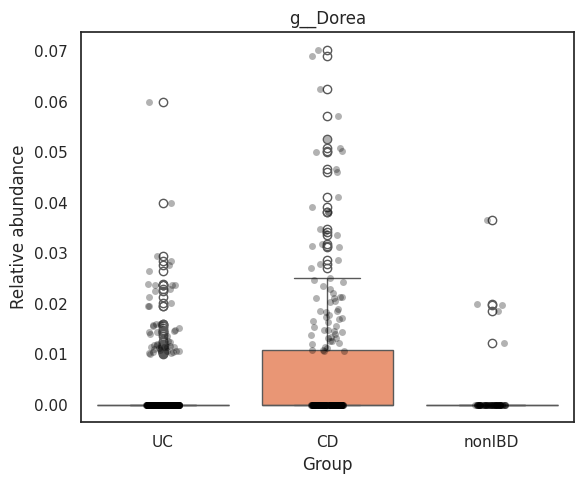

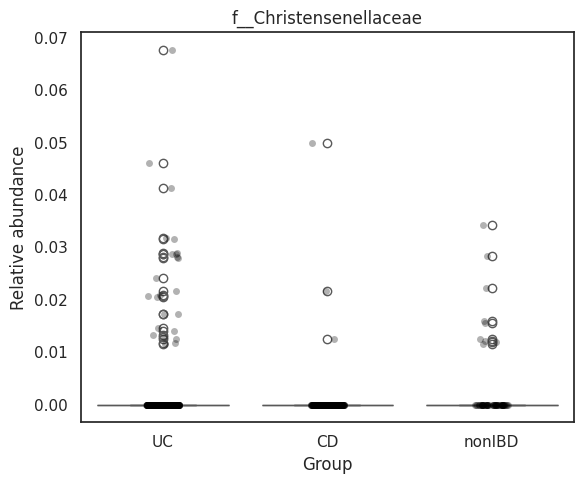

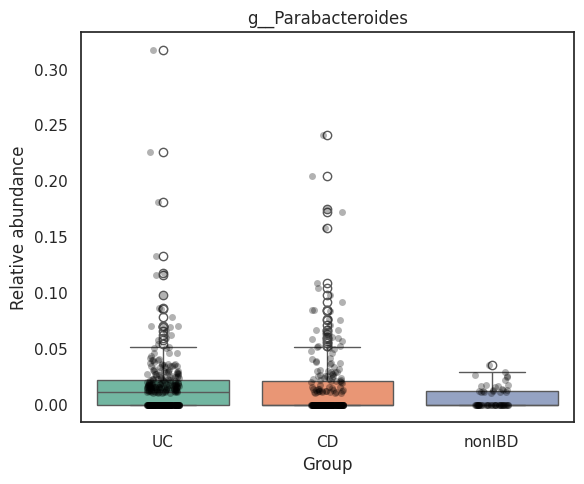

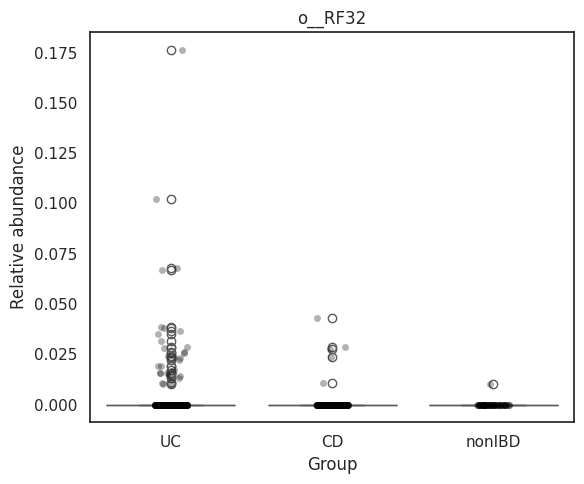

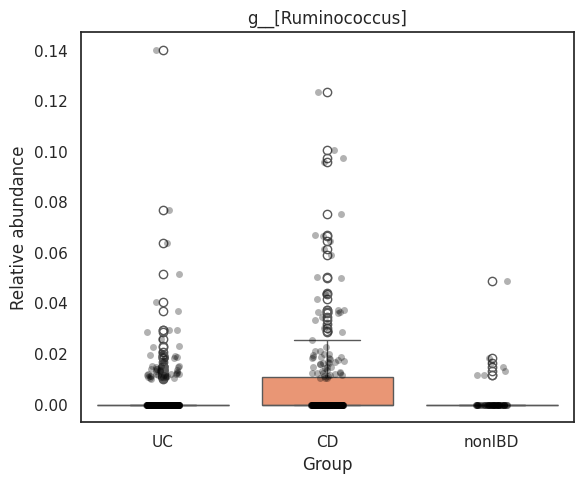

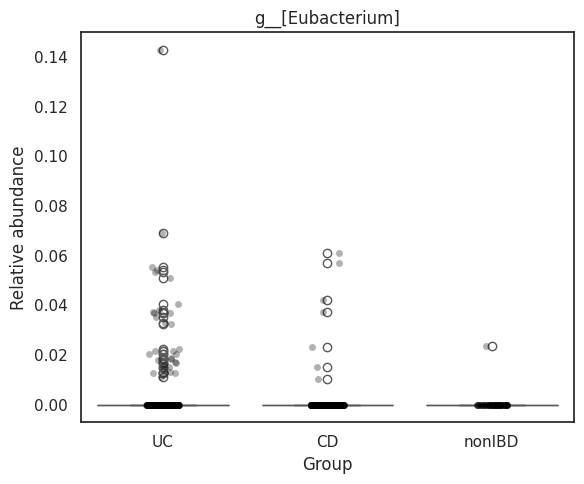

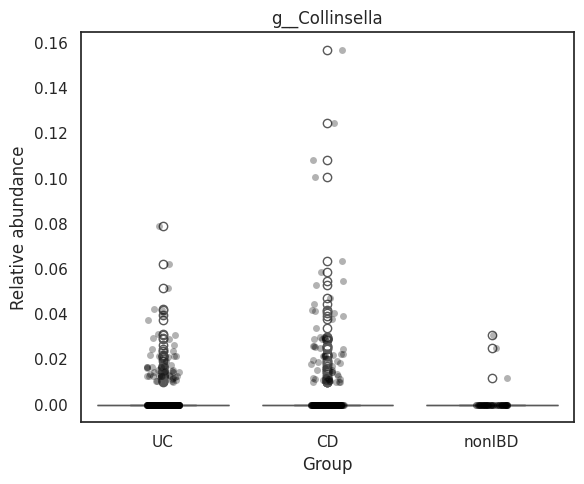

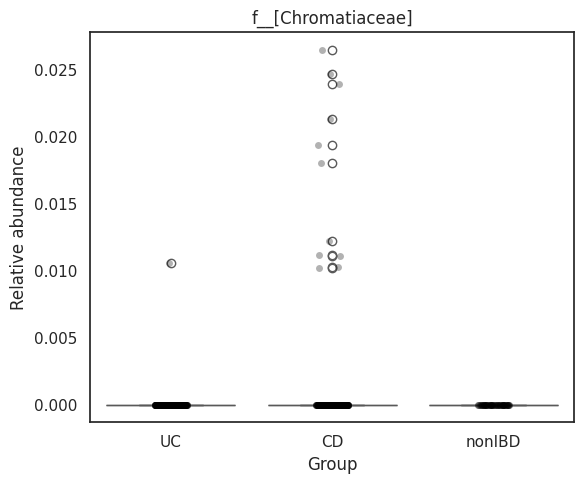

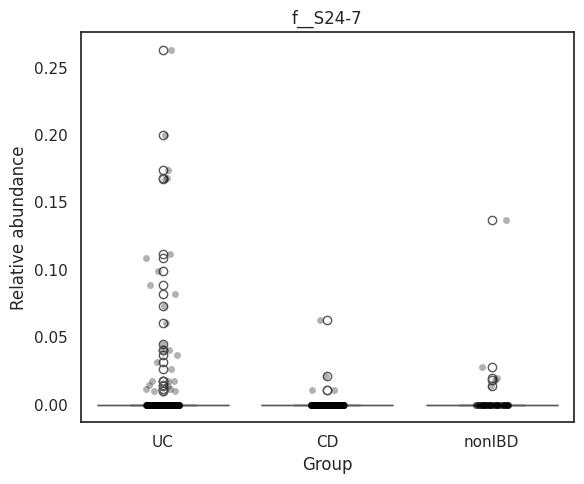

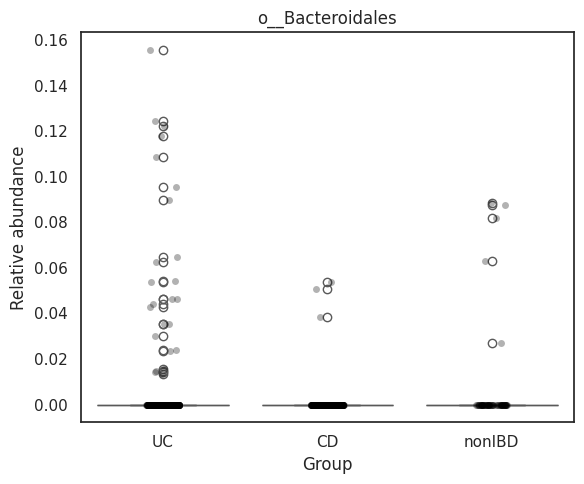

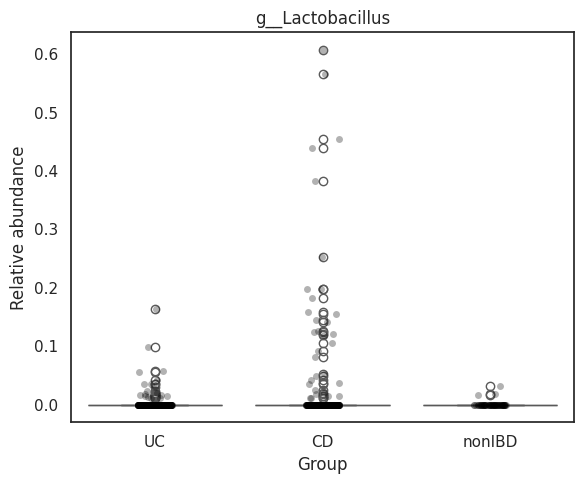

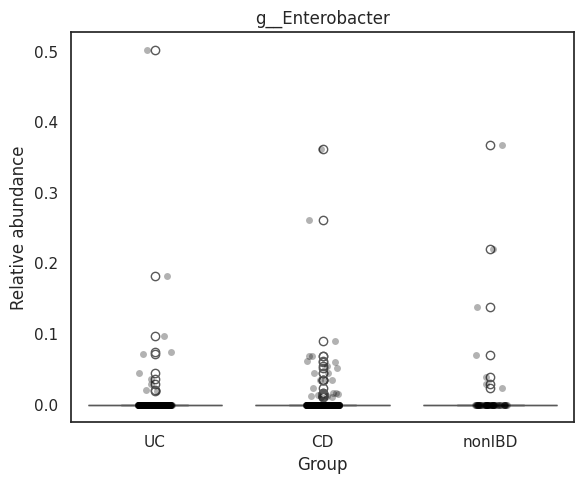

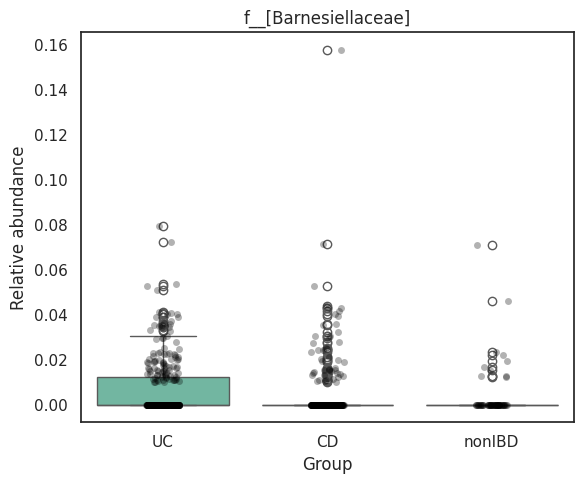

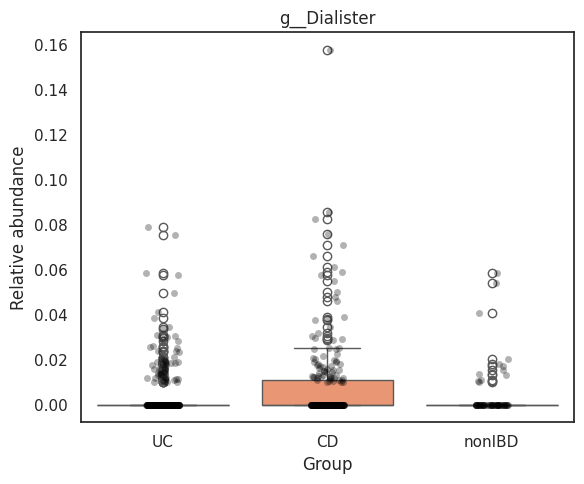

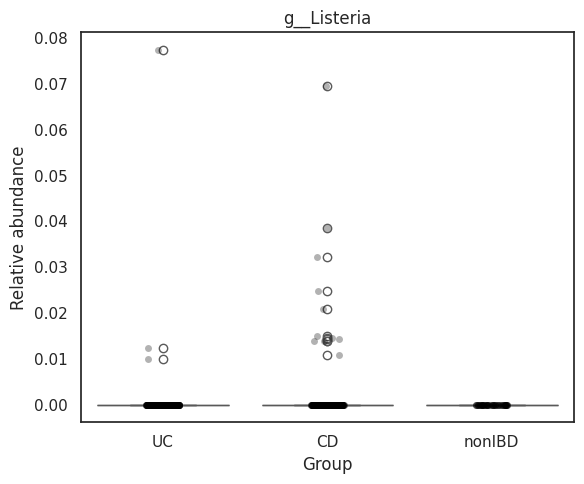

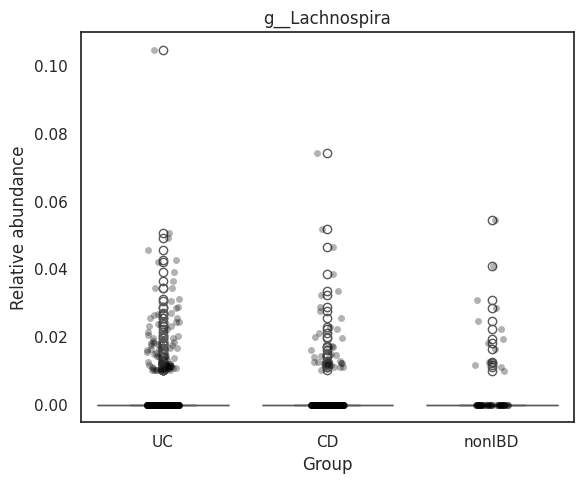

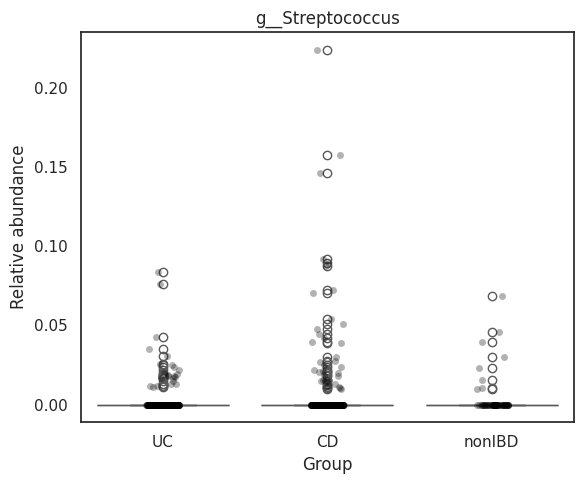

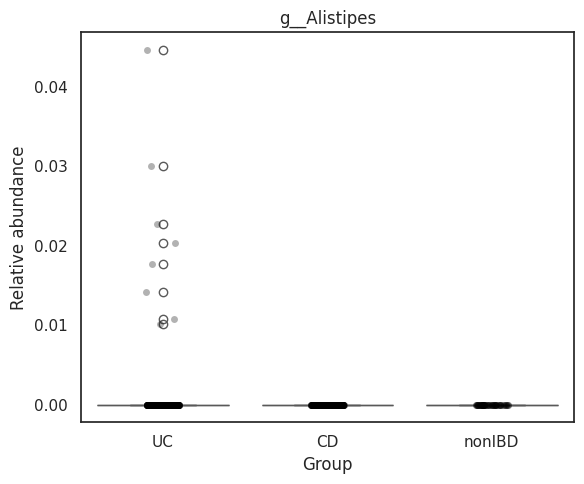

In [30]:



# select some of the features
for feature in subset:
    df_dunntest_x = X_FS[[feature]].copy()
    df_dunntest_x['Group'] = y.values
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df_dunntest_x, x='Group', y=feature, hue='Group', palette='Set2', legend=False)
    sns.stripplot(data=df_dunntest_x, x='Group', y=feature, color='black', alpha=0.3, jitter=True)
    plt.ylabel("Relative abundance")  # Replace with your desired title
    plt.title(f"{feature}")
    plt.tight_layout()
    plt.show()



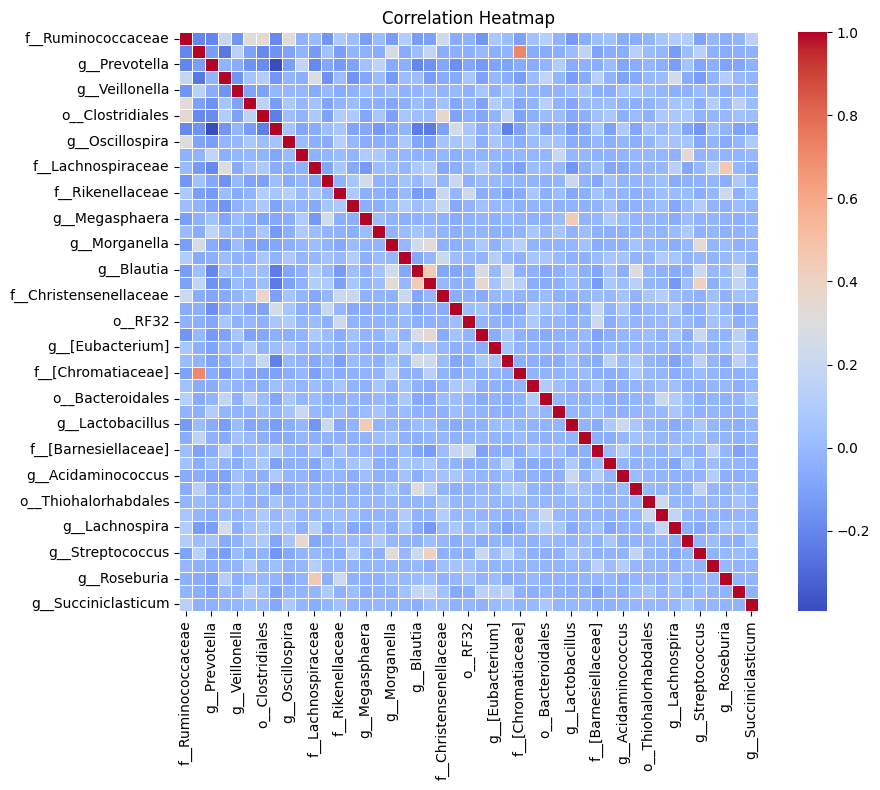

In [16]:
# Compute correlation matrix
corr = X_FS.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [17]:
X_lasso_ft0,selectedOTU_index_Lasso  = RunML.LassoFS_CV(np.array(data),target_variable)
X_lasso_ft = pd.DataFrame(X_lasso_ft0, columns=cols_name[selectedOTU_index_Lasso])

X_FS_lasso_ft0,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV(np.array(X_FS),target_variable)
selectedOTU_index_FS_lasso = selectedOTU_index[xlabel_FS_lasso_ft0]
X_FS_lasso_ft = pd.DataFrame(X_FS_lasso_ft0, columns=cols_name[selectedOTU_index_FS_lasso])

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lassofinetune":X_FS_lasso_ft
              }

Best alpha: 0.05
Best alpha: 0.05


In [18]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))


The shape of the original dataset is  (637, 220)
The shape of the SelectMicro dataset is  (637, 45)
The shape of the Lasso_finetune selected dataset is  (637, 15)
The shape of the FS_Lasso_finetune selected dataset is  (637, 14)


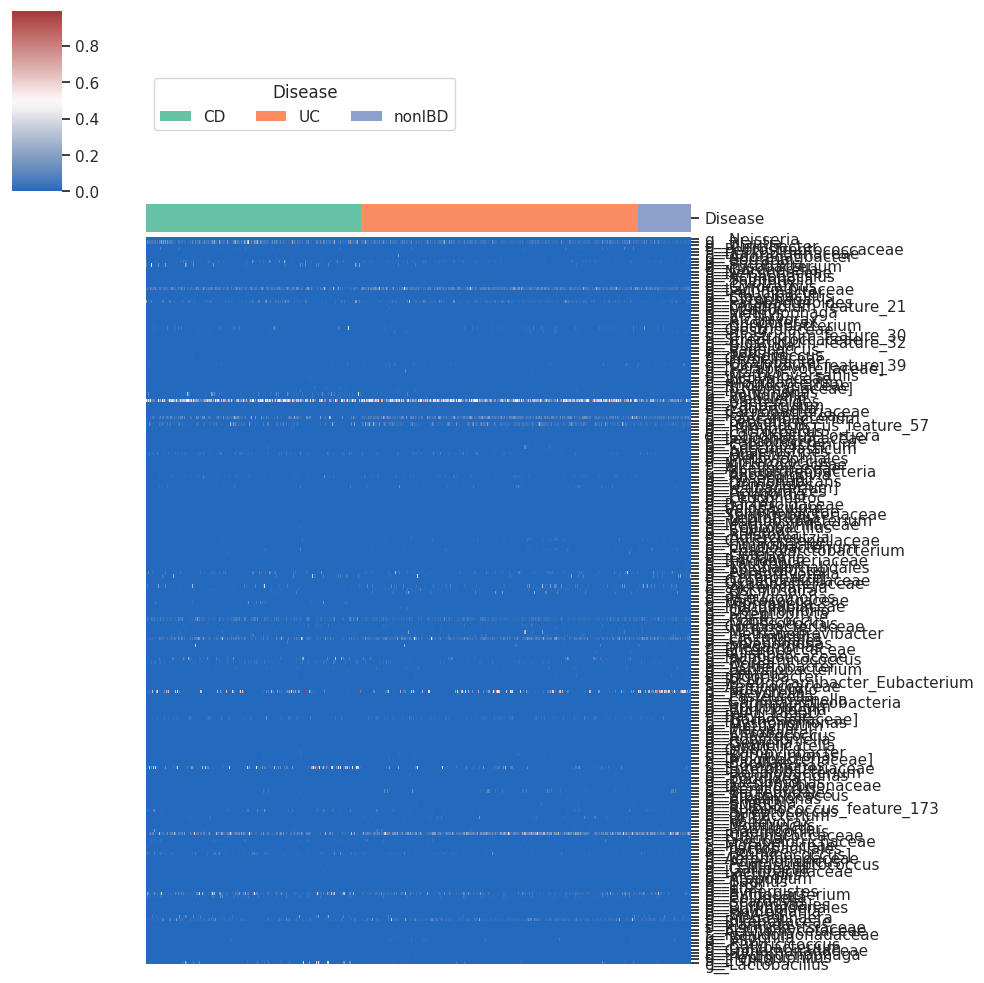

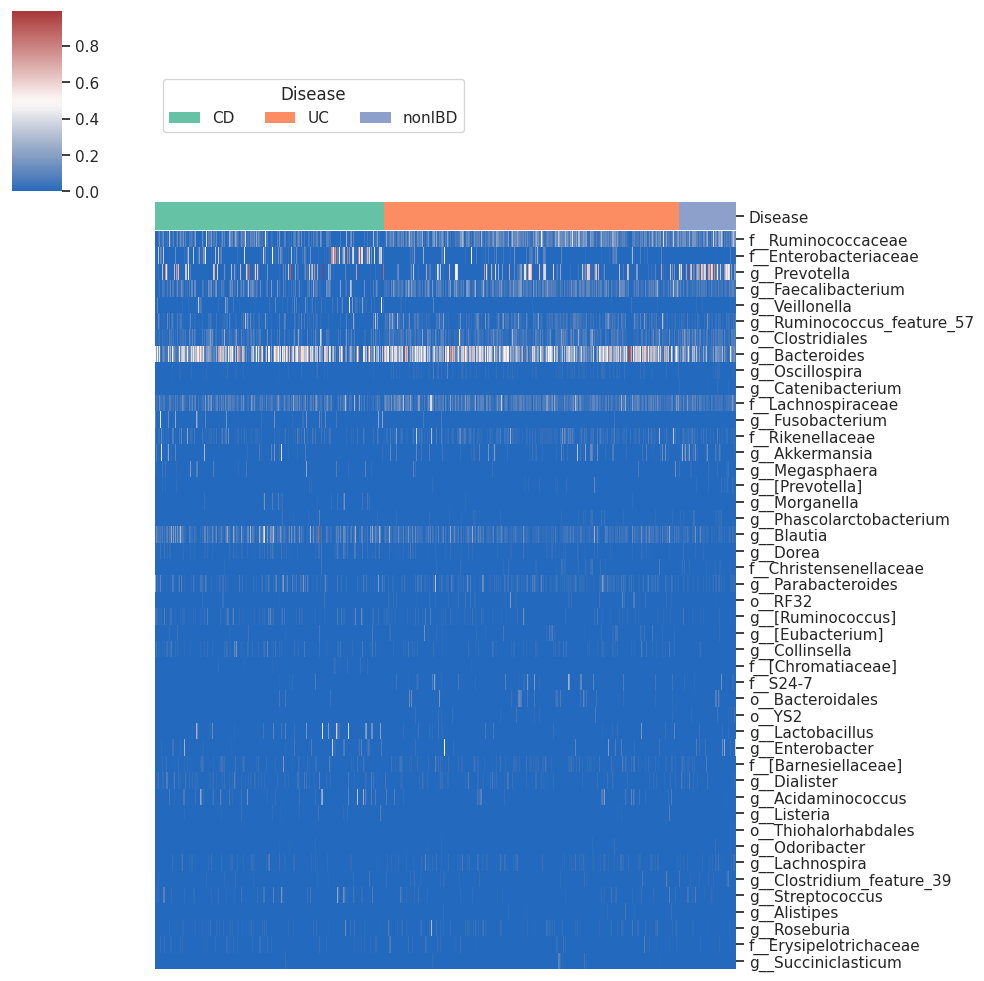

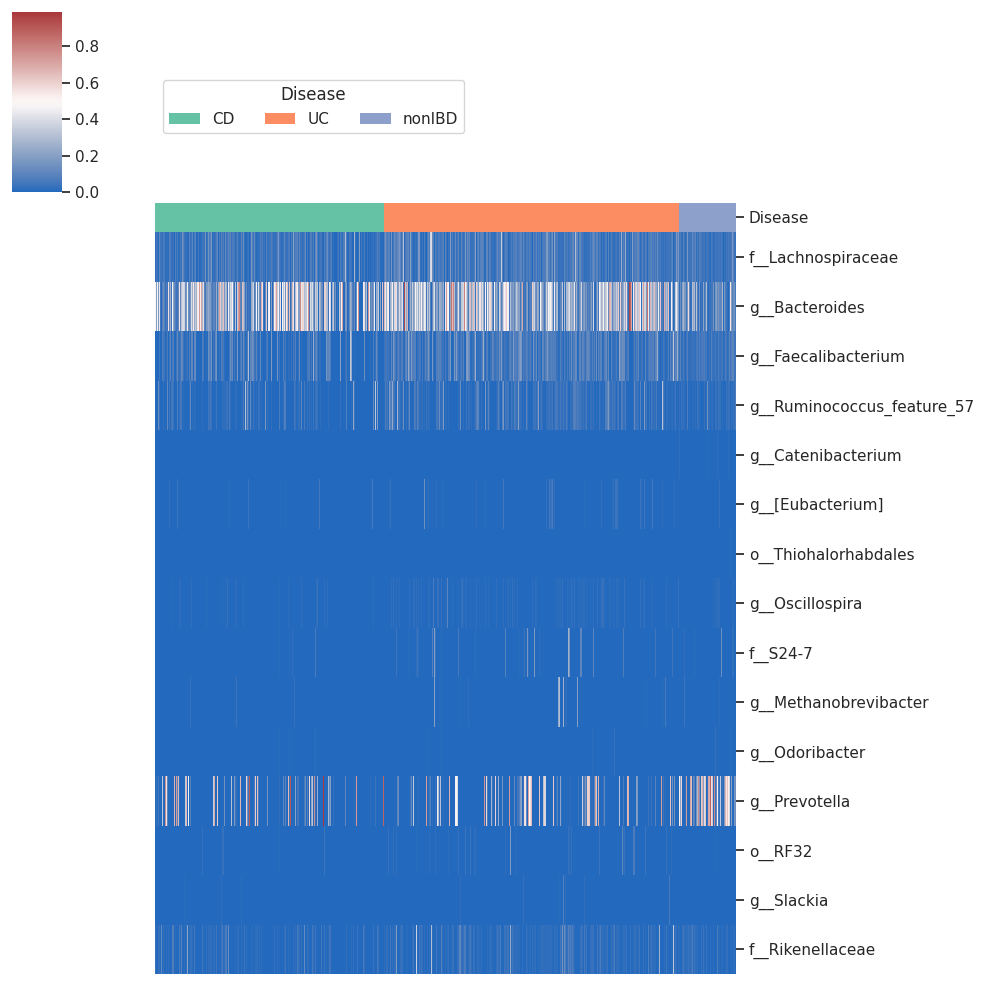

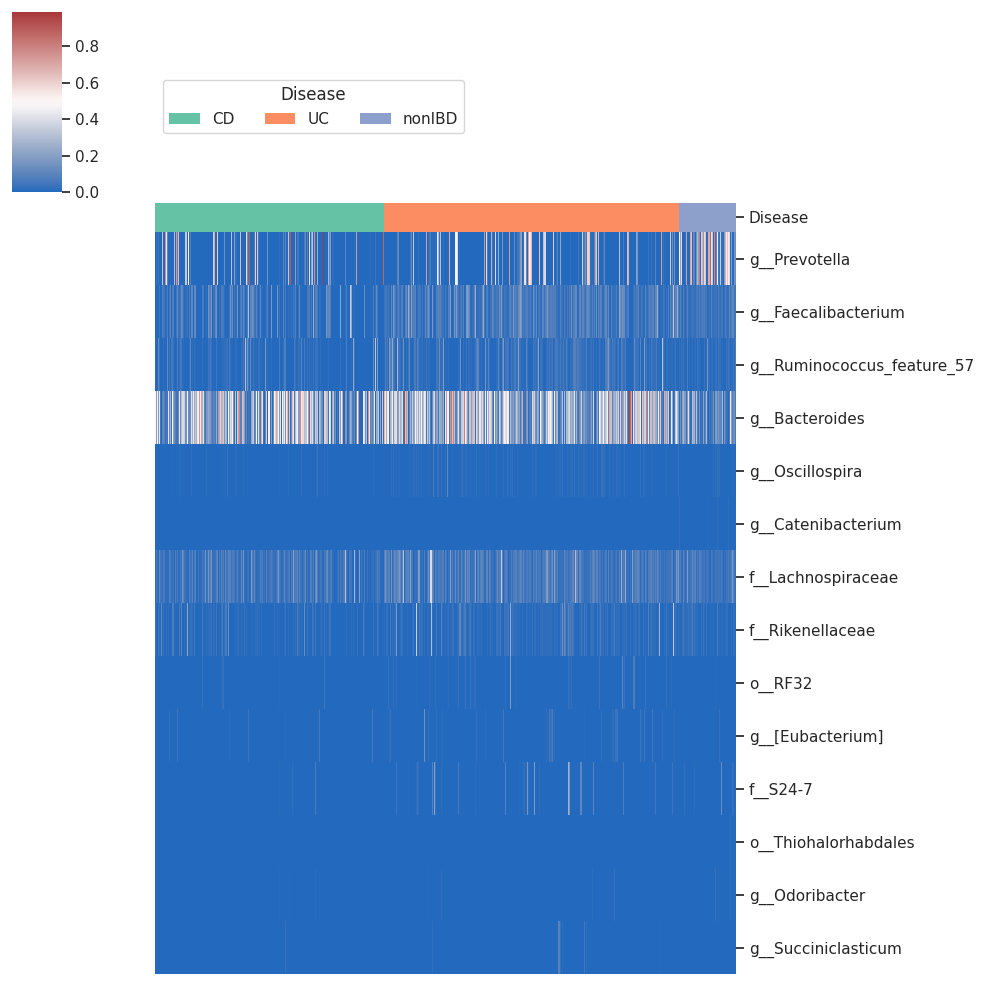

In [22]:
group = pd.DataFrame({'Disease': y})
group.index = meta_2.index
group = group.loc[qitta_2.index]

for datatype, subset in data_subset.items():
    subset.index = qitta_2.index
    metric.plot_heatmap(subset,group)
    
    
    

### plot for a feature



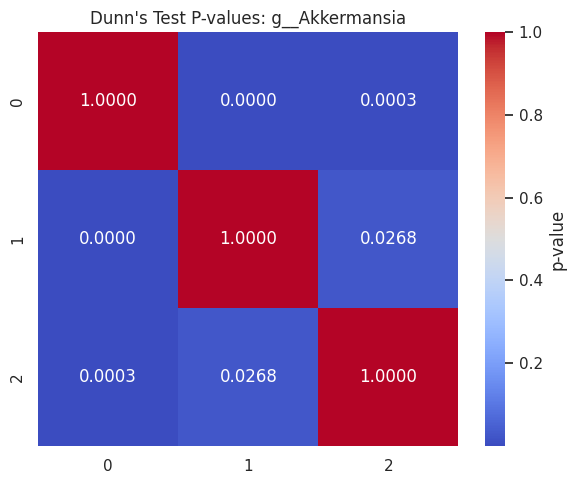

In [24]:
plt.figure(figsize=(6, 5))
sns.heatmap(dunn_results["g__Akkermansia"].astype(float), annot=True, cmap='coolwarm', fmt=".4f", cbar_kws={'label': 'p-value'})
plt.title(f"Dunn's Test P-values: g__Akkermansia")
plt.tight_layout()
#plt.savefig(os.path.join(output_diry, f"{column}_dunn_heatmap.png"))
plt.show()

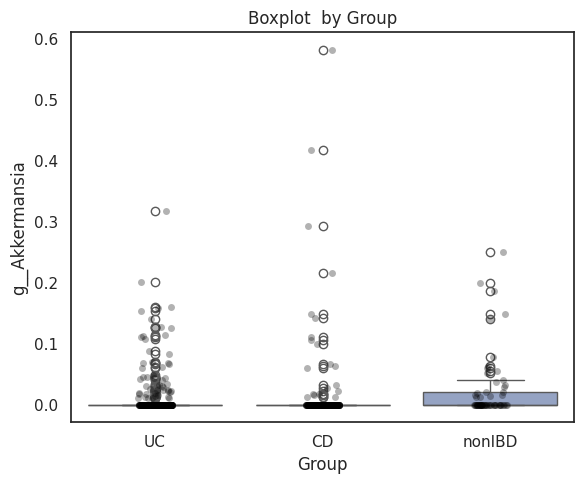

In [23]:
df_dunntest_x = X_FS[["g__Akkermansia"]].copy()
df_dunntest_x['Group'] = y.values
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_dunntest_x, x='Group', y='g__Akkermansia', hue='Group', palette='Set2', legend=False)
sns.stripplot(data=df_dunntest_x, x='Group', y='g__Akkermansia', color='black', alpha=0.3, jitter=True)
plt.title(f"Boxplot  by Group")
plt.tight_layout()
plt.show()

